In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [37]:
train, test = pd.read_csv('train.csv'), pd.read_csv('test.csv')
print('Shapes of train and test: {}, {}'.format(train.shape, test.shape))
print('Any NA: {}'.format(train.isna().any().any()))
df.loc[478587, 'signal'] = np.mean(df.signal[0:1000000]) 
df = train.copy()
df.head()

Shapes of train and test: (5000000, 3), (2000000, 2)
Any NA: False


,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [38]:
df.loc[478587, 'signal'] = np.mean(df.signal[0:1000000])

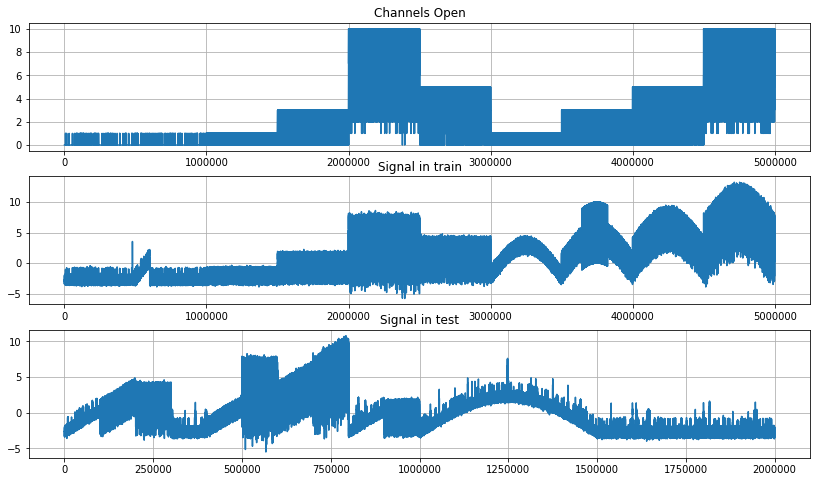

In [40]:
fig, ax = plt.subplots(3, 1, figsize=(14, 8))
ax[0].plot(df.open_channels)
ax[0].set_title('Channels Open')
ax[0].grid()
ax[1].plot(df.signal)
ax[1].set_title('Signal in train')
ax[1].grid()
ax[2].plot(test.signal)
ax[2].set_title('Signal in test')
ax[2].grid()
plt.show()

In [41]:
mean = df.signal.rolling(1000, win_type='gaussian').mean(std=400)
df['denoised_signal'] = mean 
df.iloc[:1000, -1] = df.iloc[1000:2000, -1].values
test_mean = test.signal.rolling(1000, win_type='gaussian').mean(std=400)
test['denoised_signal'] = test_mean 
test.iloc[:1000, -1] = test.iloc[1000:2000, -1].values
df.head()

,time,signal,open_channels,denoised_signal
0,0.0001,-2.7600,0,-2.692369
1,0.0002,-2.8557,0,-2.692137
2,0.0003,-2.4074,0,-2.692303
3,0.0004,-3.1404,0,-2.692241
4,0.0005,-3.1525,0,-2.691679


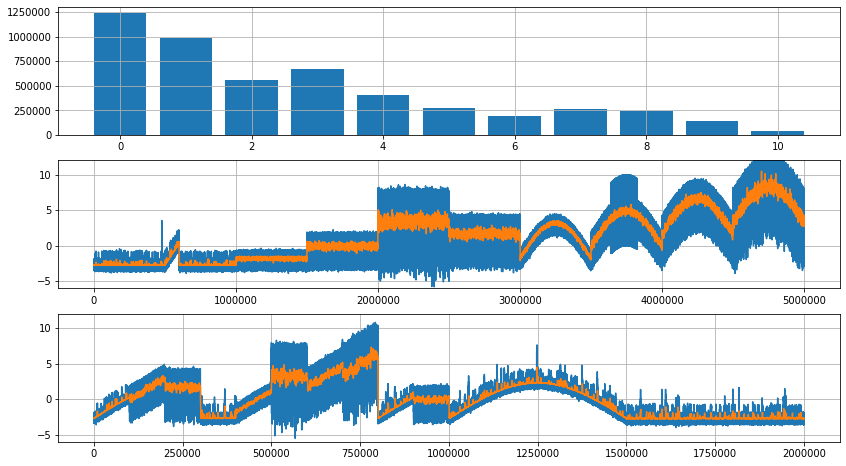

In [60]:
fig, ax = plt.subplots(3, 1, figsize=(14, 8))
ax[0].bar(df.open_channels.value_counts().index, df.open_channels.value_counts().values)
ax[0].grid()
ax[1].plot(df.signal)
ax[1].plot(df.denoised_signal)
ax[1].grid()
ax[1].set_ylim(-6, 12)
ax[2].plot(test.signal)
ax[2].plot(test.denoised_signal)
ax[2].set_ylim(-6, 12)
ax[2].grid()
plt.show()

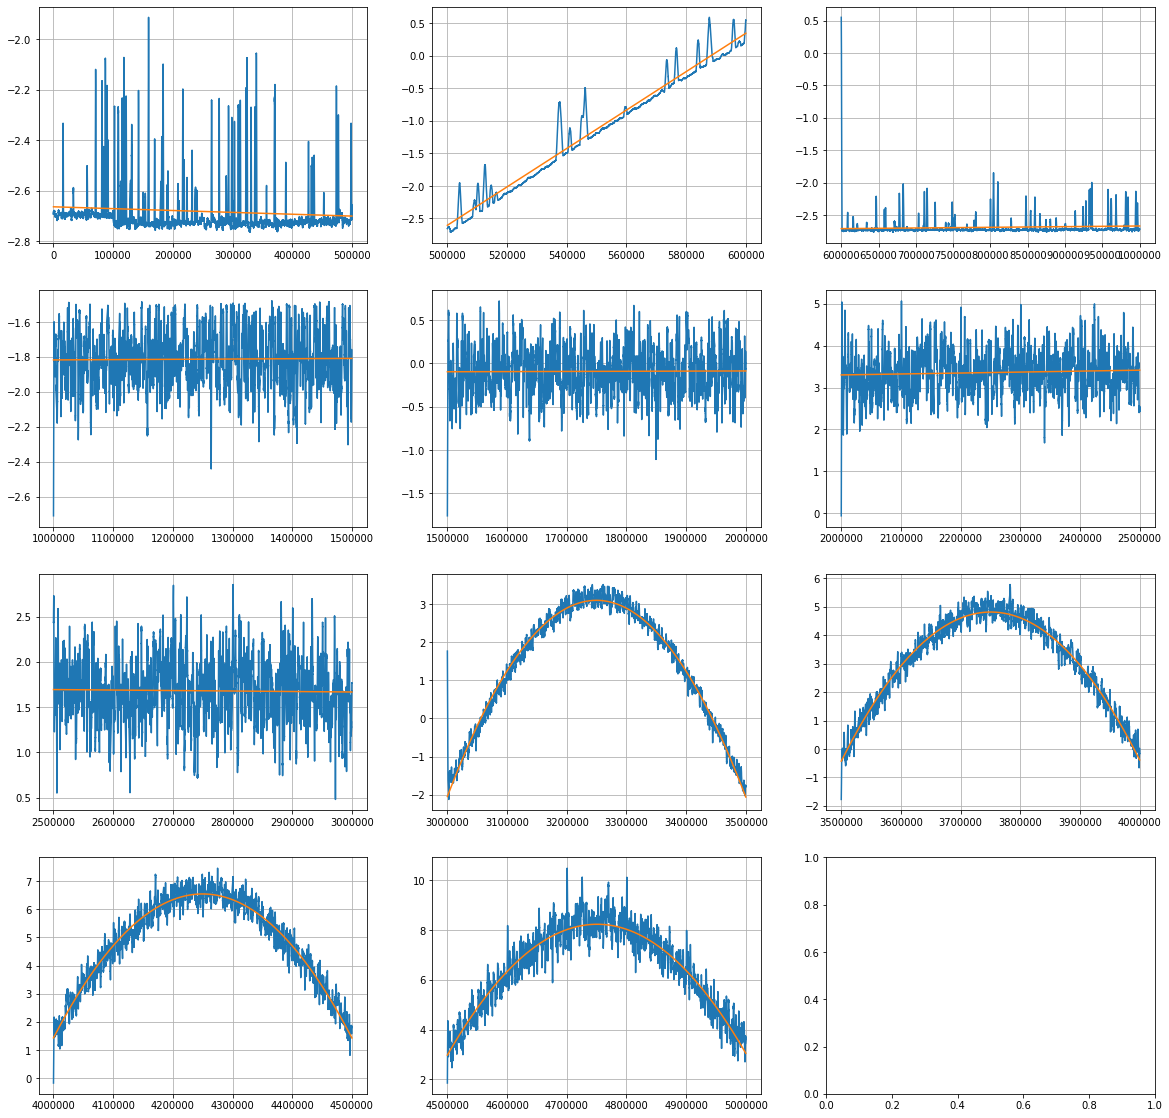

In [43]:
model = LinearRegression()
signal_cat = [1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0]
indexes = [0, 500000, 600000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000,  4500000, 4999999]
std_coeff = 2

fig, ax = plt.subplots(4, 3, figsize=(20, 20))
for i in range(4):
    for j in range(3):
        if i == 3 and j == 2:
            continue
        
        # Insert info about the number of block and the behaviour of the block (Stable, Increasing or Decrasing)
        from_, to_ = indexes[(3*i)+j], indexes[(3*i)+j+1]
        df.loc[from_:to_, 'stable'] = signal_cat[3*i+j]
        df.loc[from_:to_, 'block'] = 3*i+j
        df.loc[from_:to_, 'block_mean'] = df.loc[from_:to_, 'denoised_signal'].mean()
        df.loc[from_:to_, 'block_std'] = df.loc[from_:to_, 'denoised_signal'].std()
        df.loc[from_:to_, 'min_block_signal'] = df.loc[from_:to_, 'signal'].min()
        df.loc[from_:to_, 'max_block_signal'] = df.loc[from_:to_, 'signal'].max()
        
        # Fit a linear model of degree 1 for the Linear phase and a degr
        if signal_cat[3*i+j]:
            X = df.loc[from_:to_, 'block'].index.values.reshape(-1, 1)
        else:
            X = np.empty((df.loc[from_:to_, 'block'].shape[0], 2))
            X[:, 0] = df.loc[from_:to_, 'block'].index.values
            X[:, 1] = X[:, 0]**2
        model.fit(X, df.loc[from_:to_, 'signal'])
        y_hat = model.predict(X)
        
        # Insert information about the residual and if they are outliers
        df.loc[from_:to_, 'residual'] = (df.loc[from_:to_, 'signal'].values-y_hat)**2
        df.loc[from_:to_, 'error'] = df.loc[from_:to_, 'signal'].values-y_hat
        df.loc[from_:to_, 'error_std'] = df.loc[from_:to_, 'error'].std()
        
        # Plot signal and fitted model
        ax[i, j].plot(df.loc[from_:to_, 'denoised_signal'])
        ax[i, j].plot(np.arange(from_, to_+1), y_hat)
        ax[i, j].grid()
            
plt.show()

In [44]:
df['normalized_signal'] = df.error + df.block_mean
for block in np.unique(df.block):
    res = df.loc[df.block == block, 'residual']
    df.loc[df.block == block, 'outliers'] =  res - 2*res.std()
    df.loc[df.block == block, 'is_weak_outliers'] =  res - 2*res.std() > 0
    df.loc[df.block == block, 'is_avg_outliers'] =  res - 4*res.std() > 0
    df.loc[df.block == block, 'is_strong_outliers'] =  res - 8*res.std() > 0
    
df['is_weak_outliers'] = df['is_weak_outliers'].map({False: 0, True: 1})
df['is_avg_outliers'] = df['is_avg_outliers'].map({False: 0, True: 1})
df['is_strong_outliers'] = df['is_strong_outliers'].map({False: 0, True: 1})
    
df.head()

,time,signal,open_channels,denoised_signal,stable,block,block_mean,block_std,min_block_signal,max_block_signal,residual,error,error_std,normalized_signal,outliers,is_weak_outliers,is_avg_outliers,is_strong_outliers
0,0.0001,-2.7600,0,-2.692369,1.0,0.0,-2.681517,0.110437,-3.8506,3.5376,0.009407,-0.096989,0.32928,-2.778505,-0.574617,0,0,0
1,0.0002,-2.8557,0,-2.692137,1.0,0.0,-2.681517,0.110437,-3.8506,3.5376,0.037129,-0.192689,0.32928,-2.874205,-0.546895,0,0,0
2,0.0003,-2.4074,0,-2.692303,1.0,0.0,-2.681517,0.110437,-3.8506,3.5376,0.065337,0.255611,0.32928,-2.425905,-0.518687,0,0,0
3,0.0004,-3.1404,0,-2.692241,1.0,0.0,-2.681517,0.110437,-3.8506,3.5376,0.227900,-0.477389,0.32928,-3.158905,-0.356124,0,0,0
4,0.0005,-3.1525,0,-2.691679,1.0,0.0,-2.681517,0.110437,-3.8506,3.5376,0.239599,-0.489488,0.32928,-3.171005,-0.344425,0,0,0


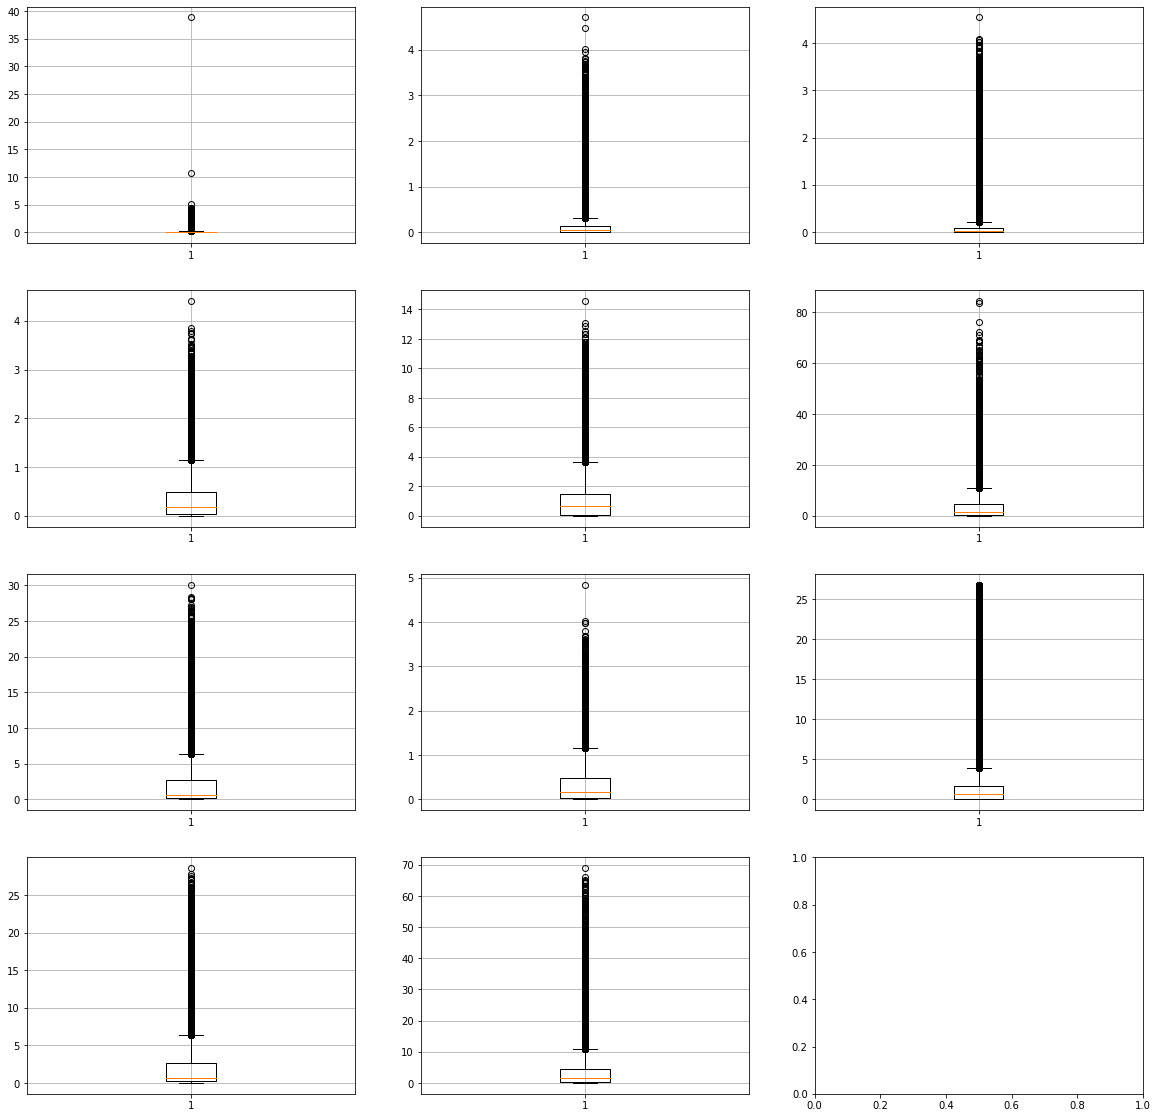

In [45]:
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
for i in range(4):
    for j in range(3):
        if i == 3 and j == 2:
            continue
        
        # Insert info about the number of block and the behaviour of the block (Stable, Increasing or Decrasing)
        from_, to_ = indexes[(3*i)+j], indexes[(3*i)+j+1]

        # Plot signal and fitted model
        ax[i, j].boxplot(df.loc[from_:to_, 'residual'])
        ax[i, j].grid()
plt.show()

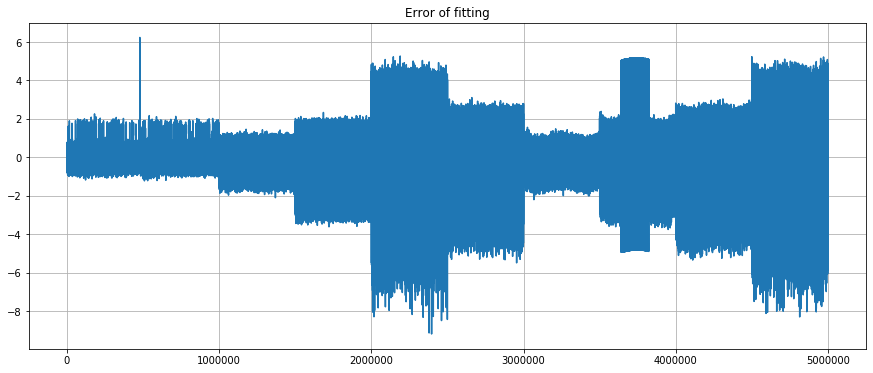

In [46]:
plt.figure(figsize = (15, 6))
df.error.plot()
plt.title('Error of fitting')
plt.grid()

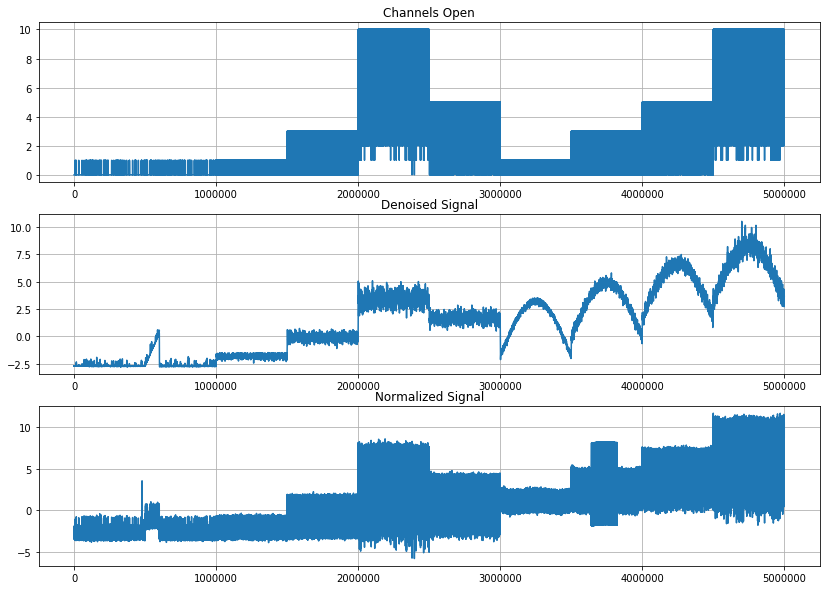

In [47]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10))
ax[0].plot(df.open_channels)
ax[0].set_title('Channels Open')
ax[0].grid()
ax[1].plot(df.denoised_signal)
ax[1].set_title('Denoised Signal')
ax[1].grid()
ax[2].plot(df.normalized_signal)
ax[2].set_title('Normalized Signal')
ax[2].grid()
plt.show()

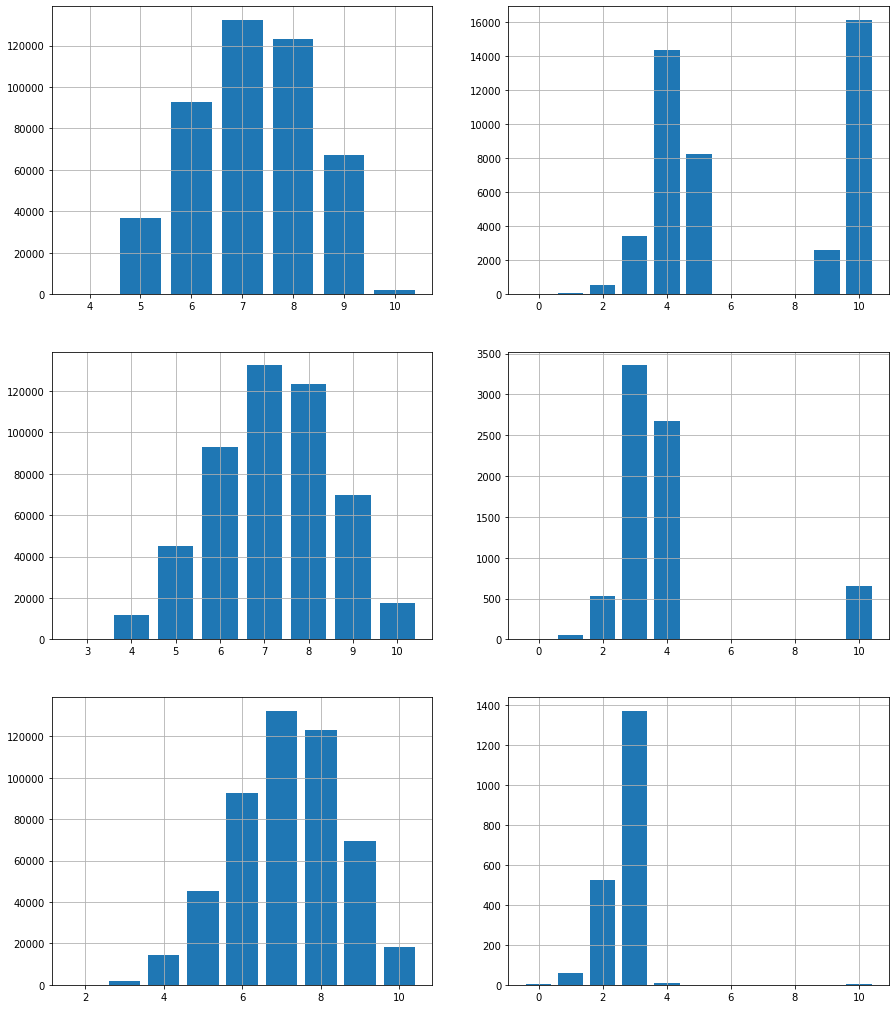

In [13]:
tmp = df[df.block == 3].copy()
tmp['is_out'] = tmp.residual > 2*tmp.residual.std()
tmp['is_out1'] = tmp.residual > 4*tmp.residual.std()
tmp['is_out2'] = tmp.residual > 6*tmp.residual.std()

fig, ax = plt.subplots(3, 2, figsize=(15, 18))
for n, cond in enumerate(['is_out', 'is_out1', 'is_out2']):
    value_counts_false = tmp.loc[tmp[cond] == False, 'open_channels'].value_counts()
    value_counts_true = tmp.loc[tmp[cond], 'open_channels'].value_counts()
    ax[n, 0].bar(value_counts_false.index, value_counts_false.values)
    ax[n, 0].grid()
    ax[n, 1].bar(value_counts_true.index, value_counts_true.values)
    ax[n, 1].grid()
plt.show()

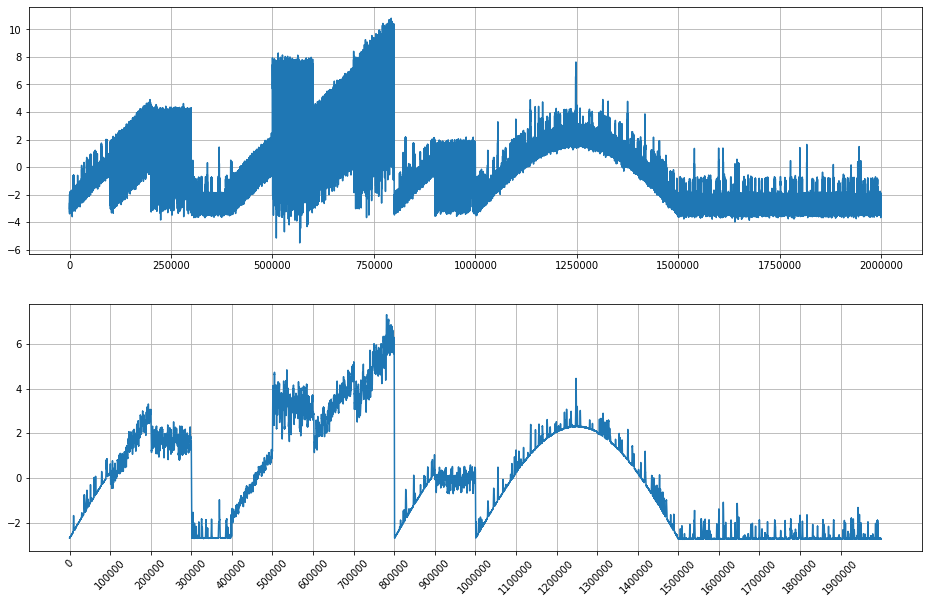

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))
ax[0].plot(test.signal)
ax[0].grid()
ax[1].plot(test.denoised_signal)
ax[1].grid()
ax[1].set_xticks([i*100000 for i in range(20)])
ax[1].set_xticklabels([i*100000 for i in range(20)], rotation=45)
plt.show()

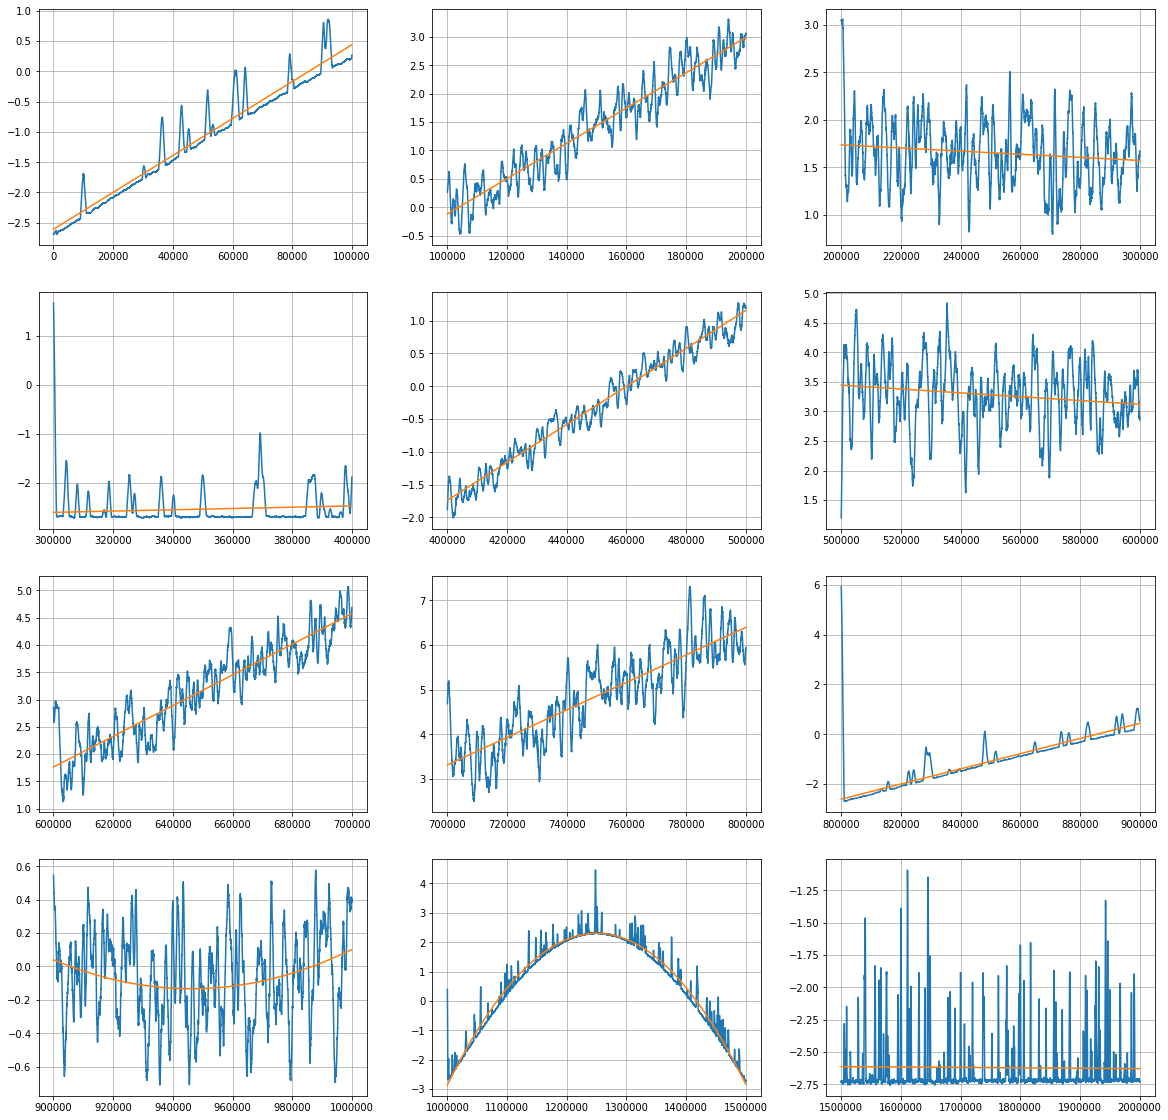

In [49]:
model = LinearRegression()
signal_cat = [2, 2, 1, 1, 2, 1, 2, 2, 1, 0, 0, 1]
indexes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20])*100000
indexes[-1] -= 1
std_coeff = 2

fig, ax = plt.subplots(4, 3, figsize=(20, 20))
for i in range(4):
    for j in range(3):
        
        # Insert info about the number of block and the behaviour of the block (Stable, Increasing or Decrasing)
        from_, to_ = indexes[(3*i)+j], indexes[(3*i)+j+1]
        test.loc[from_:to_, 'stable'] = signal_cat[3*i+j]
        test.loc[from_:to_, 'block'] = 3*i+j
        test.loc[from_:to_, 'block_mean'] = test.loc[from_:to_, 'denoised_signal'].mean()
        test.loc[from_:to_, 'block_std'] = test.loc[from_:to_, 'denoised_signal'].std()
        test.loc[from_:to_, 'min_block_signal'] = test.loc[from_:to_, 'signal'].min()
        test.loc[from_:to_, 'max_block_signal'] = test.loc[from_:to_, 'signal'].max()
        
        
        # Fit a linear model of degree 1 for the Linear phase and a degr
        if signal_cat[3*i+j]:
            X = test.loc[from_:to_, 'block'].index.values.reshape(-1, 1)
        else:
            X = np.empty((test.loc[from_:to_, 'block'].shape[0], 2))
            X[:, 0] = test.loc[from_:to_, 'block'].index.values
            X[:, 1] = X[:, 0]**2
        model.fit(X, test.loc[from_:to_, 'signal'])
        y_hat = model.predict(X)
        
        # Insert information about the residual and if they are outliers
        test.loc[from_:to_, 'residual'] = (test.loc[from_:to_, 'signal'].values-y_hat)**2
        test.loc[from_:to_, 'error'] = test.loc[from_:to_, 'signal'].values-y_hat
        test.loc[from_:to_, 'error_std'] = test.loc[from_:to_, 'error'].std()
         
        
        # Plot signal and fitted model
        ax[i, j].plot(test.loc[from_:to_, 'denoised_signal'])
        ax[i, j].plot(np.arange(from_, to_+1), y_hat)
        ax[i, j].grid()
            
plt.show()

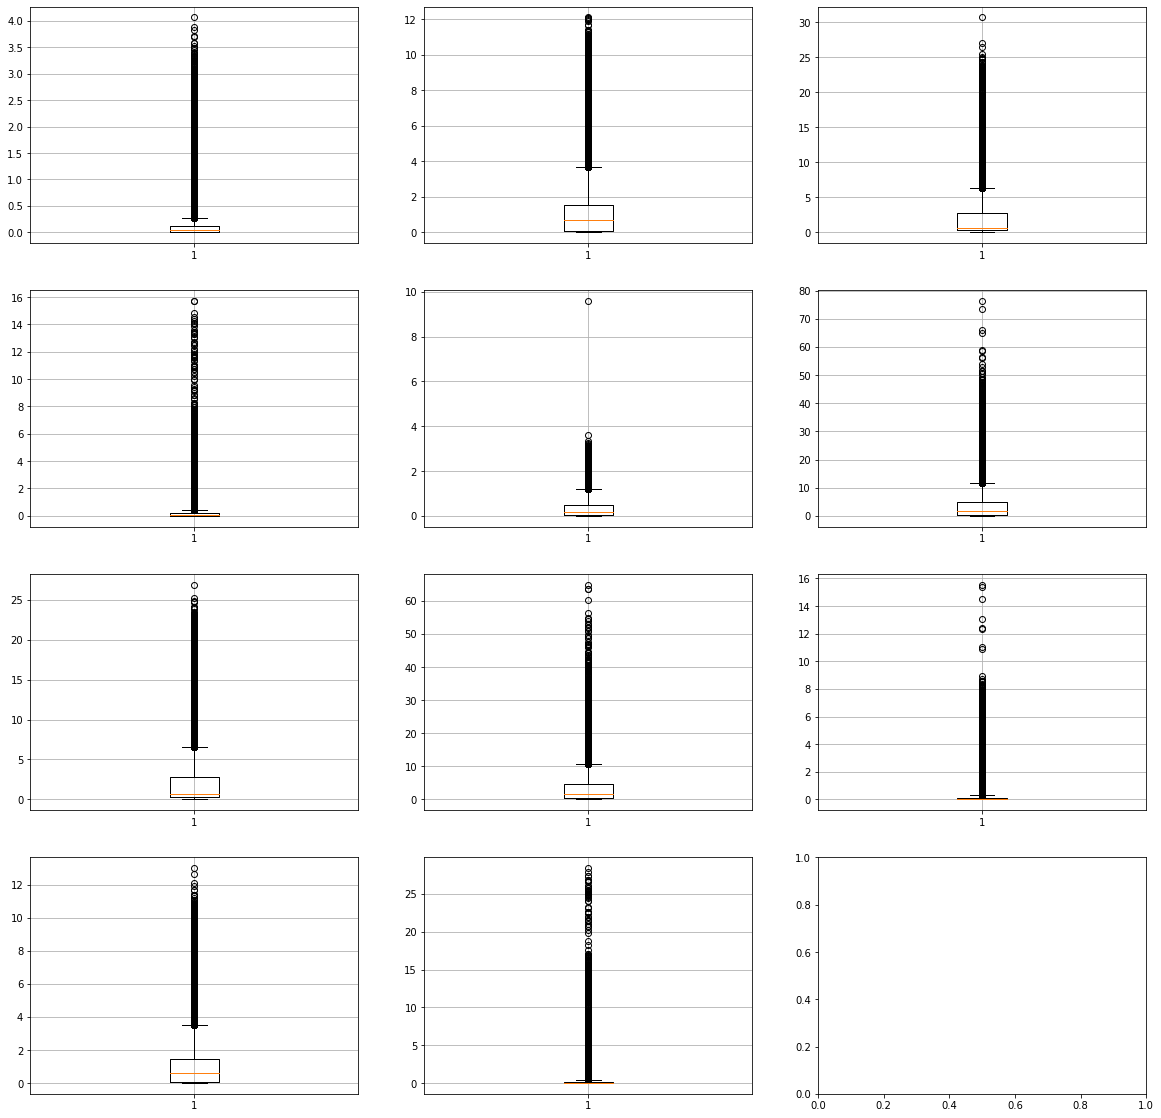

In [50]:
indexes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20])*100000
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
for i in range(4):
    for j in range(3):
        if i == 3 and j == 2:
            continue
        
        # Insert info about the number of block and the behaviour of the block (Stable, Increasing or Decrasing)
        from_, to_ = indexes[(3*i)+j], indexes[(3*i)+j+1]

        # Plot signal and fitted model
        ax[i, j].boxplot(test.loc[from_:to_, 'residual'])
        ax[i, j].grid()
plt.show()

In [51]:
test['normalized_signal'] = test.error + test.block_mean
for block in np.unique(test.block):
    res = test.loc[test.block == block, 'residual']
    test.loc[test.block == block, 'outliers'] =  res - 2*res.std()
    test.loc[test.block == block, 'is_weak_outliers'] =  res - 2*res.std() > 0
    test.loc[test.block == block, 'is_avg_outliers'] =  res - 4*res.std() > 0
    test.loc[test.block == block, 'is_strong_outliers'] =  res - 8*res.std() > 0
    

test['is_weak_outliers'] = test['is_weak_outliers'].map({False: 0, True: 1})
test['is_avg_outliers'] = test['is_avg_outliers'].map({False: 0, True: 1})
test['is_strong_outliers'] = test['is_strong_outliers'].map({False: 0, True: 1})
    
    
test.head()

,time,signal,denoised_signal,stable,block,block_mean,block_std,min_block_signal,max_block_signal,residual,error,error_std,normalized_signal,outliers,is_weak_outliers,is_avg_outliers,is_strong_outliers
0,500.0001,-2.6498,-2.688964,2.0,0.0,-1.098369,0.905024,-3.6062,2.0018,0.001797,-0.042386,0.401972,-1.140755,-0.756022,0,0,0
1,500.0002,-2.8494,-2.688599,2.0,0.0,-1.098369,0.905024,-3.6062,2.0018,0.058572,-0.242017,0.401972,-1.340386,-0.699246,0,0,0
2,500.0003,-2.8600,-2.688358,2.0,0.0,-1.098369,0.905024,-3.6062,2.0018,0.063831,-0.252647,0.401972,-1.351016,-0.693988,0,0,0
3,500.0004,-2.4350,-2.688329,2.0,0.0,-1.098369,0.905024,-3.6062,2.0018,0.029695,0.172322,0.401972,-0.926047,-0.728123,0,0,0
4,500.0005,-2.6155,-2.688431,2.0,0.0,-1.098369,0.905024,-3.6062,2.0018,0.000067,-0.008208,0.401972,-1.106577,-0.757751,0,0,0


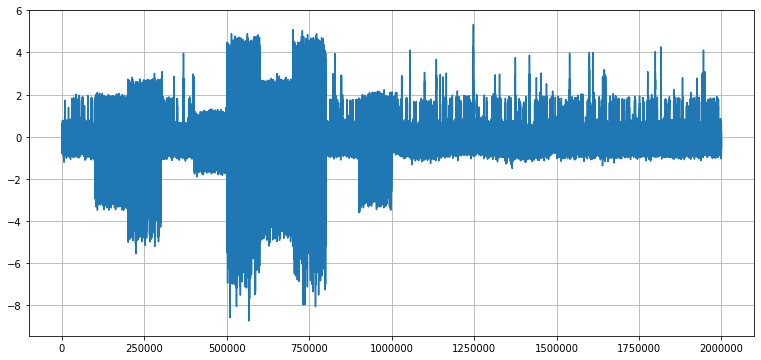

In [52]:
plt.figure(figsize = (13, 6))
test.error.plot()
plt.grid()

In [53]:
test.drop(['time', 'block'], axis=1).corr().round(3)

,signal,denoised_signal,stable,block_mean,block_std,min_block_signal,max_block_signal,residual,error,error_std,normalized_signal,outliers,is_weak_outliers,is_avg_outliers,is_strong_outliers
signal,1.000,0.937,0.140,0.866,0.400,0.012,0.744,0.302,0.347,0.707,0.933,-0.471,0.051,-0.008,0.019
denoised_signal,0.937,1.000,0.146,0.915,0.423,0.013,0.787,0.365,0.024,0.747,0.858,-0.459,0.063,0.026,-0.004
stable,0.140,0.146,1.000,0.160,-0.351,0.119,-0.091,0.176,-0.000,0.375,0.148,-0.177,0.057,0.034,-0.014
block_mean,0.866,0.915,0.160,1.000,0.463,0.015,0.860,0.394,0.000,0.816,0.928,-0.505,0.049,0.019,-0.020
block_std,0.400,0.423,-0.351,0.463,1.000,0.362,0.727,-0.048,-0.000,-0.117,0.429,0.038,-0.018,-0.011,-0.003
min_block_signal,0.012,0.013,0.119,0.015,0.362,1.000,0.026,-0.205,-0.000,-0.317,0.014,0.318,-0.007,0.008,-0.002
max_block_signal,0.744,0.787,-0.091,0.860,0.727,0.026,1.000,0.260,0.000,0.506,0.798,-0.359,0.031,-0.002,-0.013
residual,0.302,0.365,0.176,0.394,-0.048,-0.205,0.260,1.000,-0.112,0.485,0.323,0.341,0.528,0.425,0.213
error,0.347,0.024,-0.000,0.000,-0.000,-0.000,0.000,-0.112,1.000,0.000,0.373,-0.097,0.021,-0.068,0.103
error_std,0.707,0.747,0.375,0.816,-0.117,-0.317,0.506,0.485,0.000,1.000,0.757,-0.619,0.063,0.025,-0.019


In [54]:
df.drop(['time', 'block'], axis=1).corr().round(3)

,signal,open_channels,denoised_signal,stable,block_mean,block_std,min_block_signal,max_block_signal,residual,error,error_std,normalized_signal,outliers,is_weak_outliers,is_avg_outliers,is_strong_outliers
signal,1.000,0.802,0.938,-0.614,0.891,0.704,-0.055,0.808,0.250,0.345,0.784,0.955,-0.527,-0.053,-0.075,-0.001
open_channels,0.802,1.000,0.738,-0.229,0.777,0.322,-0.512,0.726,0.324,0.316,0.916,0.838,-0.609,-0.049,-0.074,-0.022
denoised_signal,0.938,0.738,1.000,-0.651,0.944,0.746,-0.058,0.856,0.333,0.013,0.830,0.885,-0.501,0.028,-0.010,0.011
stable,-0.614,-0.229,-0.651,1.000,-0.689,-0.908,-0.419,-0.621,-0.114,0.000,-0.328,-0.643,0.228,-0.021,0.014,-0.015
block_mean,0.891,0.777,0.944,-0.689,1.000,0.791,-0.061,0.907,0.350,-0.000,0.879,0.933,-0.533,0.030,-0.014,0.004
block_std,0.704,0.322,0.746,-0.908,0.791,1.000,0.347,0.701,0.157,-0.000,0.426,0.737,-0.294,0.021,-0.013,0.014
min_block_signal,-0.055,-0.512,-0.058,-0.419,-0.061,0.347,1.000,-0.060,-0.221,-0.000,-0.423,-0.057,0.296,-0.013,0.007,0.010
max_block_signal,0.808,0.726,0.856,-0.621,0.907,0.701,-0.060,1.000,0.334,-0.000,0.838,0.846,-0.538,-0.002,-0.011,0.012
residual,0.250,0.324,0.333,-0.114,0.350,0.157,-0.221,0.334,1.000,-0.192,0.408,0.257,0.447,0.547,0.430,0.297
error,0.345,0.316,0.013,0.000,-0.000,-0.000,-0.000,-0.000,-0.192,1.000,0.000,0.361,-0.162,-0.237,-0.193,-0.033


In [55]:
df.head()

,time,signal,open_channels,denoised_signal,stable,block,block_mean,block_std,min_block_signal,max_block_signal,residual,error,error_std,normalized_signal,outliers,is_weak_outliers,is_avg_outliers,is_strong_outliers
0,0.0001,-2.7600,0,-2.692369,1.0,0.0,-2.681517,0.110437,-3.8506,3.5376,0.009407,-0.096989,0.32928,-2.778505,-0.574617,0,0,0
1,0.0002,-2.8557,0,-2.692137,1.0,0.0,-2.681517,0.110437,-3.8506,3.5376,0.037129,-0.192689,0.32928,-2.874205,-0.546895,0,0,0
2,0.0003,-2.4074,0,-2.692303,1.0,0.0,-2.681517,0.110437,-3.8506,3.5376,0.065337,0.255611,0.32928,-2.425905,-0.518687,0,0,0
3,0.0004,-3.1404,0,-2.692241,1.0,0.0,-2.681517,0.110437,-3.8506,3.5376,0.227900,-0.477389,0.32928,-3.158905,-0.356124,0,0,0
4,0.0005,-3.1525,0,-2.691679,1.0,0.0,-2.681517,0.110437,-3.8506,3.5376,0.239599,-0.489488,0.32928,-3.171005,-0.344425,0,0,0


In [56]:
test.head()

,time,signal,denoised_signal,stable,block,block_mean,block_std,min_block_signal,max_block_signal,residual,error,error_std,normalized_signal,outliers,is_weak_outliers,is_avg_outliers,is_strong_outliers
0,500.0001,-2.6498,-2.688964,2.0,0.0,-1.098369,0.905024,-3.6062,2.0018,0.001797,-0.042386,0.401972,-1.140755,-0.756022,0,0,0
1,500.0002,-2.8494,-2.688599,2.0,0.0,-1.098369,0.905024,-3.6062,2.0018,0.058572,-0.242017,0.401972,-1.340386,-0.699246,0,0,0
2,500.0003,-2.8600,-2.688358,2.0,0.0,-1.098369,0.905024,-3.6062,2.0018,0.063831,-0.252647,0.401972,-1.351016,-0.693988,0,0,0
3,500.0004,-2.4350,-2.688329,2.0,0.0,-1.098369,0.905024,-3.6062,2.0018,0.029695,0.172322,0.401972,-0.926047,-0.728123,0,0,0
4,500.0005,-2.6155,-2.688431,2.0,0.0,-1.098369,0.905024,-3.6062,2.0018,0.000067,-0.008208,0.401972,-1.106577,-0.757751,0,0,0


In [57]:
for data in [df, test]:
    print('Starting memory usage for train matrix: {}'.format(np.sum(data.memory_usage())))
    for col in data.columns:
        col_mem_usage = data.memory_usage()[col]
        if col in ['stable', 'open_channels', 'block', 'is_weak_outliers', 'is_avg_outliers', 'is_strong_outliers']:
            data[col] = data[col].astype(np.int8)
        else:
            data[col] = data[col].astype(np.float32)
        print('Memory freed in {}: {}'.format(col, col_mem_usage-data.memory_usage()[col]))
    print('Ending memory usage for train matrix: {}'.format(np.sum(data.memory_usage())))

Starting memory usage for train matrix: 720000128
Memory freed in time: 20000000
Memory freed in signal: 20000000
Memory freed in open_channels: 35000000
Memory freed in denoised_signal: 20000000
Memory freed in stable: 35000000
Memory freed in block: 35000000
Memory freed in block_mean: 20000000
Memory freed in block_std: 20000000
Memory freed in min_block_signal: 20000000
Memory freed in max_block_signal: 20000000
Memory freed in residual: 20000000
Memory freed in error: 20000000
Memory freed in error_std: 20000000
Memory freed in normalized_signal: 20000000
Memory freed in outliers: 20000000
Memory freed in is_weak_outliers: 35000000
Memory freed in is_avg_outliers: 35000000
Memory freed in is_strong_outliers: 35000000
Ending memory usage for train matrix: 270000128
Starting memory usage for train matrix: 272000128
Memory freed in time: 8000000
Memory freed in signal: 8000000
Memory freed in denoised_signal: 8000000
Memory freed in stable: 14000000
Memory freed in block: 14000000
Me

In [58]:
df.to_csv('train_matrix.csv', index=False)
test.to_csv('test_matrix.csv', index=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    4.0s finished


Train metrics:	A: 0.983	F: 0.966
Test metrics:	A: 0.958	F: 0.922


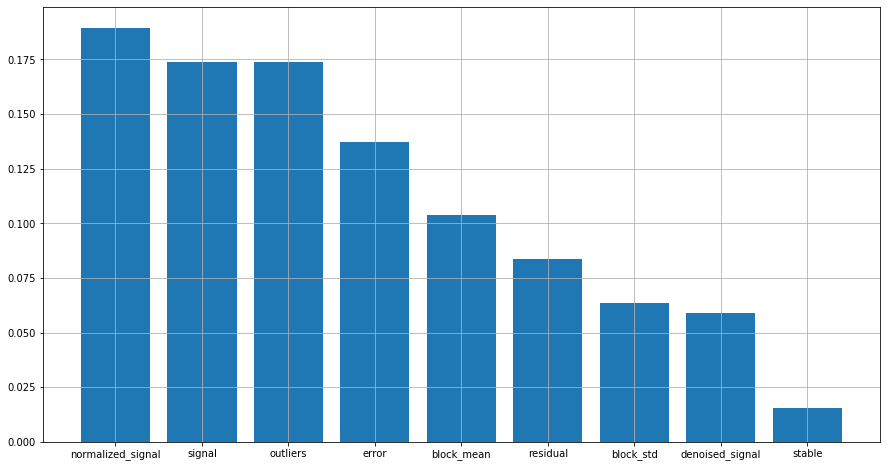

In [71]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

feat_df = df.drop(['open_channels', 'time', 'block'], axis=1)
X, y = feat_df.values, df['open_channels'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators = 10, n_jobs=-1, verbose=2, max_depth = 25)
model.fit(X_train, y_train)

y_hat_train, y_hat_test = model.predict(X_train), model.predict(X_test)

print('Train metrics:\tA: {}\tF: {}'.format(np.round(accuracy_score(y_hat_train, y_train), 3), 
                                            np.round(f1_score(y_hat_train, y_train, average='macro'), 3)))
print('Test metrics:\tA: {}\tF: {}'.format(np.round(accuracy_score(y_hat_test, y_test), 3), 
                                            np.round(f1_score(y_hat_test, y_test, average='macro'), 3)))

feat_imp = sorted(zip(model.feature_importances_, feat_df.columns), reverse = True)
name, value = [i[1] for i in feat_imp], [i[0] for i in feat_imp]

plt.figure(figsize=(15, 8))
plt.bar(name, value)
plt.grid()
plt.show()